In [92]:
from torch.nn import Sequential
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import random
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt

In [91]:
device = "cuda" if torch.cuda.is_available() else   "cpu"
print(device)

cuda


In [94]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [81]:
trainset.data.shape[0]
trainset[random.choice(range(trainset.data.shape[0]))][0].T.shape

torch.Size([32, 32, 3])

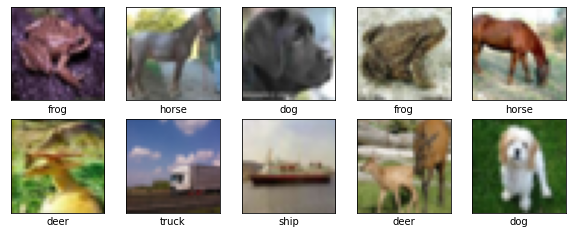

In [95]:
trainset.data[13]
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ind = random.choice(range(trainset.data.shape[0]))
    plt.imshow(trainset.data[ind])
    plt.xlabel(classes[trainset[ind][1]])
plt.show()

In [83]:



class CNN(nn.Module):
    def __init__(self,hidden_layer_size = 6):
        super().__init__()
        self.conv1 = nn.Conv2d(3, hidden_layer_size, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(hidden_layer_size, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = CNN()
# model.to(device)
crit = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

In [ ]:
hidden_layer_sizes = [6,12,18,24,30,36,42]

#arguments for adam
learning_rate = [0.0001,0.001,0.003,0.01,0.03,0.1,0.3]
betas = [(np.round(x,3),np.round(y,3)) for x,y in zip(np.arange(0.9,1,0.003),np.arange(0.9,1,0.003))]
epsilons = [np.round(x,10) for x in np.arange(1e-8,5e-8,1e-9)]


In [ ]:
#training some models
for size in hidden_layer_sizes:
    model = CNN(size)
    model.to(device)
    crit = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    for epoch in range(10):
        running_loss = 0.0
        for i,data in enumerate(trainloader,0):
            
            # inputs,labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = crit(outputs,labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i%2000 == 1999:
                print(f'{epoch+ 1}, {i+1:5d} : avg loss = {running_loss/2000:.3f}')
                running_loss = 0.0
    PATH = f'./trained_models/CNN_hid_lay_{size}.pth'
    torch.save(model.state_dict(), PATH)
    print(f'saved CNN model with hidden layer size {size}')

In [ ]:
#training a model
for epoch in range(2):
    running_loss = 0.0
    for i,data in enumerate(trainloader,0):
        inputs,labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = crit(outputs,labels)
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


In [86]:
#saving a model
model
PATH = './CNN_hid_lay_6.pth'
torch.save(model.state_dict(), PATH)

In [40]:
#loading a model
PATH = './cifar_net.pth'
net = CNN()
net.load_state_dict(torch.load(PATH))
# net.to(device)

<All keys matched successfully>

In [22]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)

        # calculate outputs by running images through the network
        outputs = net(images)
        
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [41]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
results_bigger_nn = {classname: "" for classname in classes}
results_smaller_nn = {classname: "" for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    # results_bigger_nn[classname] = f'Accuracy is {accuracy:.1f} %'
    results_smaller_nn[classname] = f'Accuracy is {accuracy:.1f} %'
for classname in classes:
    print(f"Results for class {classname} :: bigger nn: {results_bigger_nn[classname]}, smaller nn: {results_smaller_nn[classname]}")